<a href="https://colab.research.google.com/github/Yongtae723/personal_study_code/blob/main/new_york_taxi_production_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# taxiの運賃を予想するAI
Kaggleのデータセットに加えて、天気の情報pick upした場所から、drop offした場所まで最短距離をOSRM(Open Source Routing Machine)で計算した物も情報として加えた

## Kaggle のデータ

In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
!mkdir -p ~/.kaggle  #kaggleのファイルを作る
!cp kaggle.json ~/.kaggle  #kaggleのトークンをコピーする

#kaggleのアクセス権を変更する
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration

  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 84.0MB/s]
 44% 9.00M/20.3M [00:00<00:00, 51.5MB/s]
100% 20.3M/20.3M [00:00<00:00, 80.5MB/s]
 92% 58.0M/62.9M [00:03<00:00, 18.4MB/s]
100% 62.9M/62.9M [00:03<00:00, 21.4MB/s]


In [ ]:
!unzip test.zip
!unzip train.zip

Archive:  test.zip
  inflating: test.csv                
Archive:  train.zip
  inflating: train.csv               


## 天気の情報をインストール

In [ ]:
!kaggle datasets download -d mathijs/weather-data-in-new-york-city-2016

  0% 0.00/3.14k [00:00<?, ?B/s]
100% 3.14k/3.14k [00:00<00:00, 2.52MB/s]


In [ ]:
!unzip weather-data-in-new-york-city-2016

Archive:  weather-data-in-new-york-city-2016.zip
  inflating: weather_data_nyc_centralpark_2016(1).csv  


## OSRMのデータはgithubに落ちてた

In [ ]:
!git clone https://github.com/PaulEmmanuelSotir/NYC_TaxiTripDuration.git

Cloning into 'NYC_TaxiTripDuration'...
remote: Enumerating objects: 275, done.
remote: Total 275 (delta 0), reused 0 (delta 0), pack-reused 275
Receiving objects: 100% (275/275), 387.20 MiB | 40.10 MiB/s, done.
Resolving deltas: 100% (171/171), done.
Checking out files: 100% (15/15), done.


In [ ]:
!unzip ./NYC_TaxiTripDuration/NYC_taxi_data_2016/osrm/fastest_routes_test.zip
!unzip ./NYC_TaxiTripDuration/NYC_taxi_data_2016/osrm/fastest_routes_train_part_1.zip
!unzip ./NYC_TaxiTripDuration/NYC_taxi_data_2016/osrm/fastest_routes_train_part_2.zip

Archive:  ./NYC_TaxiTripDuration/NYC_taxi_data_2016/osrm/fastest_routes_test.zip
  inflating: fastest_routes_test.csv  
Archive:  ./NYC_TaxiTripDuration/NYC_taxi_data_2016/osrm/fastest_routes_train_part_1.zip
  inflating: fastest_routes_train_part_1.csv  
Archive:  ./NYC_TaxiTripDuration/NYC_taxi_data_2016/osrm/fastest_routes_train_part_2.zip
  inflating: fastest_routes_train_part_2.csv  


## data処理

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost
%matplotlib inline

from subprocess import check_output
# print(check_output(["ls", "input/"]).decode("utf8"))

In [ ]:
df = pd.read_csv('train.csv')
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [ ]:
#dataのメモリの量をへらす
print(f" memory amount of before data is {df.memory_usage().sum()/2**20}")
df.passenger_count = df.passenger_count.astype(np.uint8)
df.vendor_id = df.vendor_id.astype(np.uint8)
df.trip_duration = df.trip_duration.astype(np.uint32)
for c in [c for c in df.columns if c.endswith('tude')]:
    df.loc[:,c] = df[c].astype(np.float32)
print(f" memory amount of after data is {df.memory_usage().sum()/2**20}")

#インストールしたデータの"daytime"のdtyoeがobjectだったので変換する
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime=pd.to_datetime(df.dropoff_datetime)


df['pu_hour'] = df.pickup_datetime.dt.hour
df['yday'] = df.pickup_datetime.dt.dayofyear
df['wday'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month
df.head()

 memory amount of before data is 122.41435241699219
 memory amount of after data is 75.11792755126953


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,164,6,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,19,1,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,97,2,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,86,5,3


In [ ]:
df.dtypes

id                            object
vendor_id                      uint8
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                uint8
pickup_longitude             float32
pickup_latitude              float32
dropoff_longitude            float32
dropoff_latitude             float32
store_and_fwd_flag            object
trip_duration                 uint32
pu_hour                        int64
yday                           int64
wday                           int64
month                          int64
dtype: object

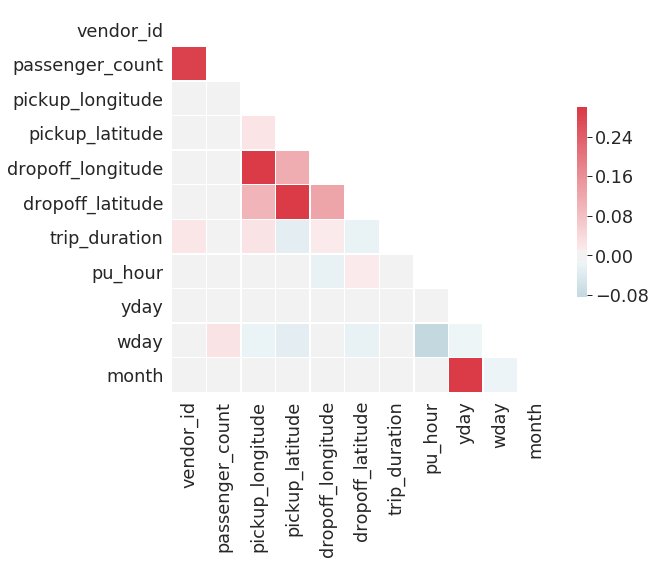

In [ ]:
#データの相関を見る
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)#corrと同じ型ですべての要素がFalseの配列
mask[np.triu_indices_from(mask)] = True#上三角行列をTrueに
f, ax = plt.subplots(figsize=(9,7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

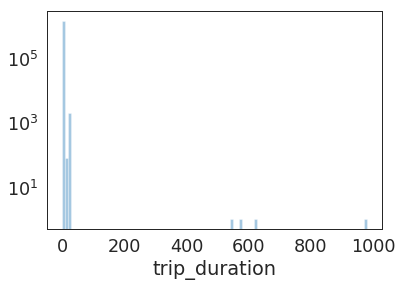

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.distplot(df['trip_duration']/3600,ax=ax,bins=100,kde=False,hist_kws={'log':True})

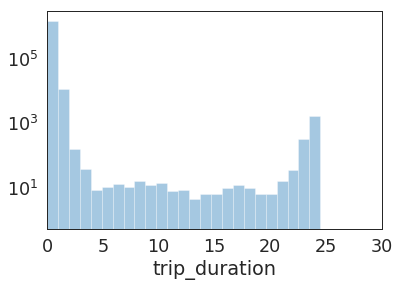

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlim(0,30)
sns.distplot(df['trip_duration']/3600,ax=ax,bins=1000,kde=False,hist_kws={'log':True})

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
  """
  地球のような球面における2点間の距離はhaversine formula(球面三角法)で計算される
  """
  lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

  c = 2 * np.arcsin(np.sqrt(a))
  km = 6367 * c
  miles = km *  0.621371
  return miles

In [ ]:
df['distance'] = haversine(df.pickup_longitude, df.pickup_latitude,
                                           df.dropoff_longitude, df.dropoff_latitude)

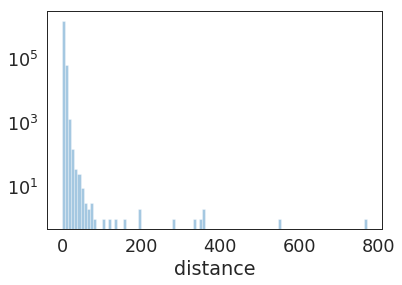

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.distplot(df['distance'],ax=ax,bins=100,kde=False,hist_kws={'log':True})

In [ ]:
#about weather
wdf = pd.read_csv('weather_data_nyc_centralpark_2016(1).csv')
wdf.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [ ]:
wdf['date']=pd.to_datetime(wdf.date,format='%d-%m-%Y')
wdf['yday'] = wdf.date.dt.dayofyear

In [ ]:
wdf.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,yday
0,2016-01-01,42,34,38.0,0.00,0.0,0,1
1,2016-01-02,40,32,36.0,0.00,0.0,0,2
2,2016-01-03,45,35,40.0,0.00,0.0,0,3
3,2016-01-04,36,14,25.0,0.00,0.0,0,4
4,2016-01-05,29,11,20.0,0.00,0.0,0,5


In [ ]:

#weatherのtable微小の降水量があると"T"と表示されるらしい。。。しかしなぜTを0.05に変換するのか不明
wdf['snowfall'] = wdf['snow fall'].replace(['T'],0.05).astype(np.float32)
wdf['precipitation'] = wdf['precipitation'].replace(['T'],0.05).astype(np.float32)
wdf['snowdepth'] = wdf['snow depth'].replace(['T'],0.05).astype(np.float32)

In [ ]:
df = pd.merge(df,wdf,on='yday')


In [ ]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pu_hour', 'yday', 'wday', 'month', 'distance', 'date',
       'maximum temperature', 'minimum temperature', 'average temperature',
       'precipitation', 'snow fall', 'snow depth', 'snowfall', 'snowdepth'],
      dtype='object')

In [ ]:
df = df.drop(['date','maximum temperature','minimum temperature'],axis=1)

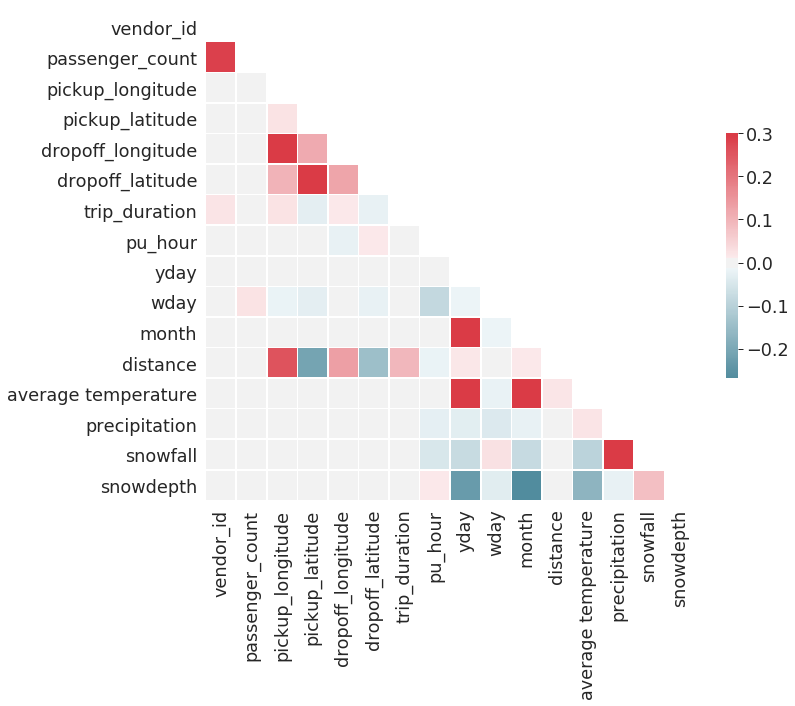

In [ ]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

In [ ]:
corr

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snowfall,snowdepth
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,0.009299,-0.006025,0.001311,-0.006221,0.008109,-0.005760,0.001385,0.000207,0.006036
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471,0.009101,-0.001784,0.025191,-0.002143,0.010306,-0.001203,0.001415,0.000510,0.000733
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.010150,0.004263,-0.016356,0.004474,0.259780,0.005547,0.001418,-0.003288,0.003602
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204,0.010603,-0.002516,-0.028976,-0.001439,-0.210354,-0.002011,-0.004180,-0.005058,-0.000112
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,-0.022455,0.004612,-0.001130,0.004758,0.134033,0.005502,0.001660,0.000774,0.001092
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677,0.013612,-0.001554,-0.021762,-0.000607,-0.142128,-0.000997,-0.002710,-0.002434,0.000454
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000,0.003690,0.006625,-0.000708,0.006607,0.094777,0.004574,-0.002590,-0.000190,0.002716
pu_hour,0.009299,0.009101,0.010150,0.010603,-0.022455,0.013612,0.003690,1.000000,-0.003340,-0.084255,-0.003438,-0.015813,-0.004948,-0.028656,-0.048589,0.014215
yday,-0.006025,-0.001784,0.004263,-0.002516,0.004612,-0.001554,0.006625,-0.003340,1.000000,-0.013615,0.985657,0.016443,0.837212,-0.031407,-0.077248,-0.229351
wday,0.001311,0.025191,-0.016356,-0.028976,-0.001130,-0.021762,-0.000708,-0.084255,-0.013615,1.000000,-0.014544,0.007599,-0.019799,-0.041673,0.028427,-0.034647


In [ ]:
fastest1 = pd.read_csv('fastest_routes_train_part_1.csv')
fastest2 = pd.read_csv('fastest_routes_train_part_2.csv')
fastest = pd.concat([fastest1,fastest2],ignore_index=True)
fastest = fastest.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
fastest.head() #

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [ ]:
#上記のidとdfのidが同じなのでDataFrameをmergeする
df = pd.merge(df,fastest,on='id',how='outer')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224526,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3


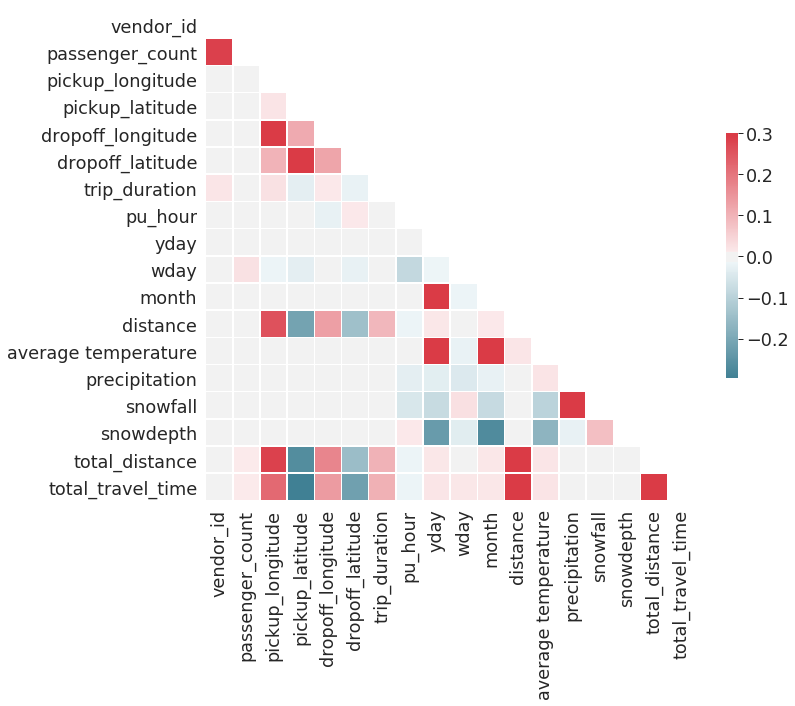

In [ ]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

In [ ]:
#外れ値の排除
mask = ((df.trip_duration > 60) & (df.distance < 0.05))
df = df[~mask]
mask = (df.trip_duration < 60) 
df = df[~mask]
mask =  df.trip_duration > 79200
df = df[~mask]
mask = df.distance/(df.trip_duration/3600) > 60
df = df[~mask]
df.trip_duration = df.trip_duration.astype(np.uint16)
df = df[df.passenger_count > 0]

In [ ]:
m = df.groupby(['wday','vendor_id'])[['trip_duration']].apply(np.median)
m.name = 'trip_duration_median'
df = df.join(m, on=['wday','vendor_id'])

In [ ]:
print(m)

wday  vendor_id
0     1            633.0
      2            634.0
1     1            679.0
      2            685.0
2     1            694.0
      2            700.0
3     1            707.0
      2            719.0
4     1            689.0
      2            690.0
5     1            638.0
      2            641.0
6     1            604.0
      2            606.0
Name: trip_duration_median, dtype: float64


In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9,634.0
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224526,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6,633.0
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9,633.0
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8,634.0
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3,634.0


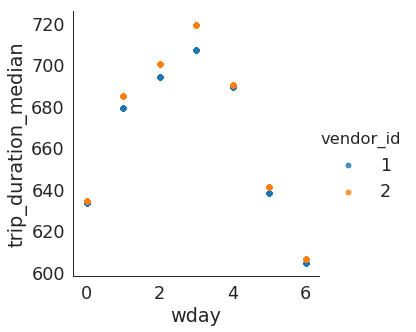

In [ ]:
sns.lmplot(y='trip_duration_median', x='wday',data=df, fit_reg=False, hue='vendor_id')

In [ ]:

m = df.groupby(['pu_hour','vendor_id'])[['trip_duration']].apply(np.median)
m.name ='trip_duration_median_hour'
df = df.join(m, on=['pu_hour','vendor_id'])

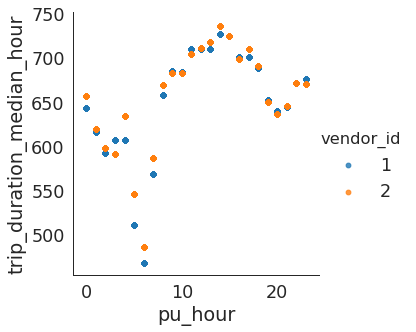

In [ ]:
sns.lmplot(y='trip_duration_median_hour', x='pu_hour',data=df, fit_reg=False, hue='vendor_id')

In [ ]:
#ジョンFケネディ国際空港の場所
jfk_lon = -73.778889
jfk_lat = 40.639722

#ラガーディア国際空港の場所
lga_lon = -73.872611
lga_lat = 40.77725

In [ ]:
#国際空港でタクシーを乗った人間かどうかを判断するために乗降した場所と2つの国際空港の距離を調べる
df['jfk_pickup_dist'] = df.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
df['lga_pickup_dist'] = df.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
df['jfk_dropoff_dist'] = df.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
df['lga_dropoff_dist'] = df.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)

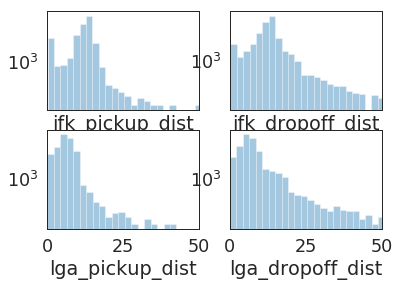

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True)
ax[0,0].set_xlim(0,50)

sns.distplot(df['jfk_pickup_dist'],ax=ax[0,0],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['jfk_dropoff_dist'],ax=ax[0,1],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['lga_pickup_dist'],ax=ax[1,0],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['lga_dropoff_dist'],ax=ax[1,1],bins=100,kde=False,hist_kws={'log':True})

In [ ]:
df['jfk'] = ((df['jfk_pickup_dist'] < 2) | (df['jfk_dropoff_dist'] < 2))
df['lga'] = ((df['lga_pickup_dist'] < 2) | (df['lga_dropoff_dist'] < 2))
df = df.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median,trip_duration_median_hour,jfk,lga
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9,634.0,709.0,False,False
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224526,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6,633.0,727.0,False,False
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9,633.0,724.0,False,False
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8,634.0,633.5,False,False
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3,634.0,735.0,False,False


In [ ]:
df['workday'] = ((df['pu_hour'] > 8) & (df['pu_hour'] < 18))
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,total_distance,total_travel_time,trip_duration_median,trip_duration_median_hour,jfk,lga,workday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,45.5,0.29,0.0,0,0.0,0.0,2009.1,164.9,634.0,709.0,False,False,True
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,14,74,0,3,1.224526,45.5,0.29,0.0,0,0.0,0.0,2782.9,244.6,633.0,727.0,False,False,True
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994484,40.745087,-73.998993,40.722710,N,695,15,74,0,3,1.563173,45.5,0.29,0.0,0,0.0,0.0,3124.4,419.9,633.0,724.0,False,False,True
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944359,40.714489,-73.910530,40.709492,N,755,4,74,0,3,1.803944,45.5,0.29,0.0,0,0.0,0.0,3327.8,280.8,634.0,633.5,False,False,False
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952881,40.766468,-73.978630,40.761921,N,1050,14,74,0,3,1.382826,45.5,0.29,0.0,0,0.0,0.0,3354.8,270.3,634.0,735.0,False,False,True


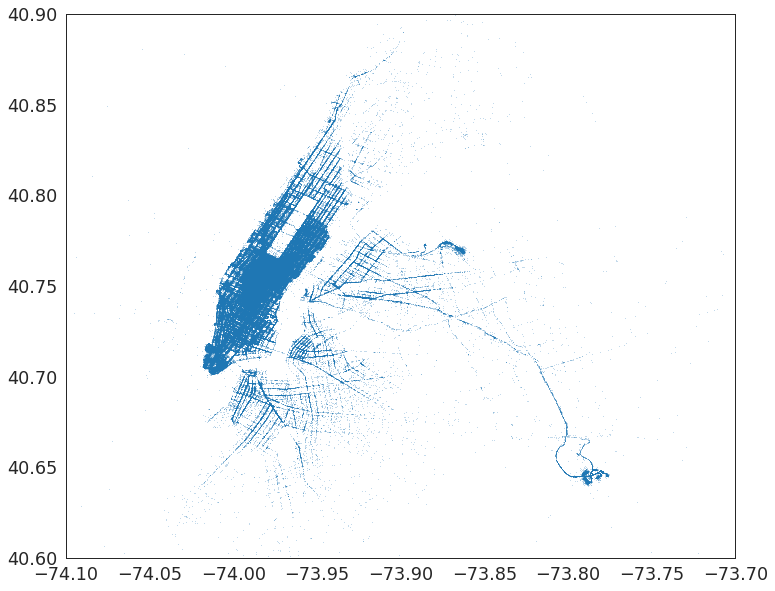

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(df['pickup_longitude'],df['pickup_latitude'], s=0.01, alpha=1)

## RMSLE: Evaluation Metric
RMSLE (Root Mean Squared Logarithmic Error)はRMSE (Root Mean Squared Error)の改良版
logを取ることで、外れ値に強く、より正規分布に近いErrorを生むことが出来る。
詳細は[ここ](http://data-analysis-stats.jp/2019/04/29/rmsle-%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99/)で


In [ ]:
def rmsle(evaluator,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5

## Load Test Data

In [ ]:
tdf = pd.read_csv('test.csv')
tdf.pickup_datetime=pd.to_datetime(tdf.pickup_datetime)
#tdf.dropoff_datetime=pd.to_datetime(tdf.dropoff_datetime)
tdf['pu_hour'] = tdf.pickup_datetime.dt.hour
tdf['yday'] = tdf.pickup_datetime.dt.dayofyear
tdf['wday'] = tdf.pickup_datetime.dt.dayofweek
tdf['month'] = tdf.pickup_datetime.dt.month
tdf['distance'] = haversine(tdf.pickup_longitude, tdf.pickup_latitude,
                                           tdf.dropoff_longitude, tdf.dropoff_latitude)

In [ ]:
fastest_test = pd.read_csv('fastest_routes_test.csv')
tdf = pd.merge(tdf,fastest_test,on='id',how='outer')
tdf = tdf.drop(['step_location_list','step_direction','step_maneuvers','travel_time_per_step','distance_per_step','street_for_each_step','number_of_steps','starting_street','end_street'],axis=1)
tdf = pd.merge(tdf,wdf,on='yday')
tdf = tdf.drop(['date','maximum temperature','minimum temperature'],axis=1)

In [ ]:
tdf.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'pu_hour', 'yday', 'wday',
       'month', 'distance', 'total_distance', 'total_travel_time',
       'average temperature', 'precipitation', 'snow fall', 'snow depth',
       'snowfall', 'snowdepth'],
      dtype='object')

In [ ]:
tdf['jfk_pickup_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['lga_pickup_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['jfk_dropoff_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['lga_dropoff_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['jfk'] = ((tdf['jfk_pickup_dist'] < 2) | (tdf['jfk_dropoff_dist'] < 2))
tdf['lga'] = ((tdf['lga_pickup_dist'] < 2) | (tdf['lga_dropoff_dist'] < 2))
tdf = tdf.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
tdf['workday'] = ((tdf['pu_hour'] > 8) & (tdf['pu_hour'] < 18))

In [ ]:
tdf['snowfall'] = tdf['snow fall'].replace(['T'],0.05)
tdf['precipitation'] = tdf['precipitation'].replace(['T'],0.05)
tdf['snowdepth'] = tdf['snow depth'].replace(['T'],0.05)
tdf.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pu_hour,yday,wday,month,distance,total_distance,total_travel_time,average temperature,precipitation,snow fall,snow depth,snowfall,snowdepth,jfk,lga,workday
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,182,3,6,1.705478,3795.9,424.6,76.0,0.0,0.0,0,0.0,0,False,False,False
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,182,3,6,1.713435,2904.5,200.0,76.0,0.0,0.0,0,0.0,0,False,False,False
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,182,3,6,0.811098,1499.5,193.2,76.0,0.0,0.0,0,0.0,0,False,False,False
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,182,3,6,3.272003,7023.9,494.8,76.0,0.0,0.0,0,0.0,0,False,False,False
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,182,3,6,0.596664,1108.2,103.2,76.0,0.0,0.0,0,0.0,0,False,False,False


## データの保存

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Kggle data of Taxi in New York')

In [ ]:
# os.mkdir('Kggle data of Taxi in New York')
# os.chdir('Kggle data of Taxi in New York')

In [ ]:
df.to_csv('train_data.csv',index=False)
tdf.to_csv('test_data.csv',index=False)

## Benchmark Model

In [ ]:
benchmark = fastest_test[['id','total_travel_time']]
benchmark = benchmark.rename(index=str, columns={"total_travel_time": "trip_duration"})
benchmark.head()

,id,trip_duration
0,id0771704,200.2
1,id3274209,141.5
2,id2756455,324.6
3,id3684027,84.2
4,id3101285,294.7


In [ ]:
benchmark['trip_duration'].isnull().values.any()
benchmark.to_csv('benchmark.csv',index=False)
#RMSLE=0.990

### 以下の解析でtotal_travel_timeを入れるのはさすがにチート感がある。。。
時間の洋右があればこれ抜きでPredictionしてみよう

In [ ]:
features = df[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','precipitation','snowfall','snowdepth','total_distance','total_travel_time','jfk','lga']]
target = df['trip_duration']

In [ ]:
#Columnsはtestと同じ
tfeatures = tdf[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','precipitation','snowfall','snowdepth','total_distance','total_travel_time','jfk','lga']]

# Ai解析

In [ ]:
df = pd.read_csv('train_data.csv')
tdf = pd.read_csv('test_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Linear Regression

In [ ]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv, scoring=rmsle))
reg.fit(features, target)

Number predicted less than 0: (14,)
Number predicted less than 0: (9,)
Number predicted less than 0: (17,)
Number predicted less than 0: (12,)
[0.43999626 0.44022776 0.43897465 0.44073689]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
tfeatures.shape

(625134, 17)

In [ ]:
pred = reg.predict(tfeatures)
print(np.where(pred < 0)[0].shape)
pred[pred < 0]=0

(490,)


In [ ]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]

In [ ]:
out['trip_duration'].isnull().values.any()

False

In [ ]:
out.to_csv('pred_linear.csv',index=False)
#RMSLE=0.535

## K-nearest Neighbors Regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(neigh, features, np.ravel(target), cv=cv,scoring=rmsle))
neigh.fit(features,target)

Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[0.42011203 0.4194096  0.41947696 0.41968832]


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [ ]:
pred = neigh.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(0,)


In [ ]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out.to_csv('pred_knn.csv',index=False)
#RMSLE=0.505

## Ramdom Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(rf, features, np.ravel(target), cv=cv,scoring=rmsle))
rf = rf.fit(features,np.ravel(target))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number predicted less than 0: (0,)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number predicted less than 0: (0,)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number predicted less than 0: (0,)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number predicted less than 0: (0,)
[0.3503923  0.35071053 0.35024337 0.35079207]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
pred = rf.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(0,)


In [ ]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out.to_csv('pred_rf.csv',index=False)
#RMSLE=0.473

## XGBoost

In [ ]:
reg = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv,scoring=rmsle))
reg.fit(features,target)

[01:49:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[02:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[02:24:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[02:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Number predicted less than 0: (0,)
[0.34320702 0.3440338  0.34316219 0.3432831 ]


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[03:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

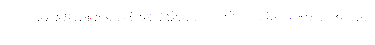

In [ ]:
from xgboost import plot_tree
plot_tree(reg)

In [ ]:
import pickle
pickle.dump(reg, open('xgb_model.sav','wb'),protocol=2)